# The exponential kernel.

## Functional Methods in Machine Learning 
Final exam

Due date: Monday, 2022/03/07, 13:00


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy as np
from scipy import stats
from sklearn import datasets
import matplotlib.pyplot as plt


import kernel_approximation as ka
import kernel_machine_learning as kml
import stochastic_plots as stoch

## Generation of random samples: Inverse transform sampling.

Consider a real-valued random variable whose pdf is $f(x)$. 
The corresponding cdf is
$$
F(x) = \int_{-\infty}^{x} dx' f(x').
$$
This inverse of the cdf ($F^{-1}(p)$) can be used to generate random numbers from this distribution using the following algorithm:

1. Generate a sample from the $U[0,1]$ distribution $\left\{u_m \right\}_{m=1}^M $ with $ u_m \sim U[0,1]$.
2. The sample $\left\{w_m = F^{-1}(u_m) \right\}_{m=1}^M $ is such that $w_m \sim f(w)$. 

For instance, the pdf of an exponential distribution defined on the set of non-negative real numbers is
$$
f(x) = \lambda e^{-\lambda x},   x \ge 0,
$$
with $\lambda > 0$.

The corresponding cdf is
$$
F(x) = \int_{0}^{x} dx \lambda e^{-\lambda x} = 1 - e^{-\lambda x}, \  x \ge 0.
$$
The inverse of the cdf is such that $ F^{-1}(p) = x$.
Since $p = F(x) = 1 -e^{-\lambda x}$, $x = - \log (1-p) / \lambda$. Therefore, 
$$
F^{-1}(p) = -\frac{1}{\lambda} \log (1-p), \ 0 \le p \le 1.
$$
See, for instance, [ https://en.wikipedia.org/wiki/Exponential_distribution ]

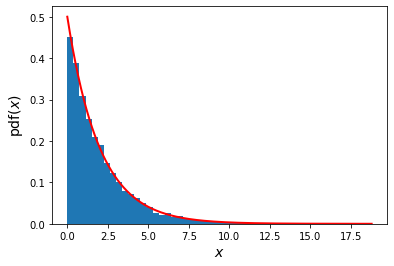

In [2]:
# Generate samples from the exponential distribution.

# Exponential distribution
def exp_pdf(x, gamma):
    return  np.exp(- x / gamma) / gamma

def exp_cdf(x, lambd):
    return 1.0 - np.exp(- x / gamma)

def exp_inverse_cdf(p, gamma):
    return - gamma * np.log(1.0 - p) 

# Inverse transform sampling.

gamma = 2.0

n_samples = 10000
U = np.random.rand(n_samples) # U ~ U[0, 1]
X = exp_inverse_cdf(U, gamma)

# Define a range for the plot. 

X_min, X_max = (np.min(X), np.max(X))

fontsize = 14
fig, ax = stoch.plot_pdf(
    X, 
    lambda x: exp_pdf(x, gamma), 
    fontsize=fontsize, 
    fig_num=1,
)
_ = ax.set_xlabel('$x$', fontsize=fontsize)
_ = ax.set_ylabel('pdf($x$)', fontsize=fontsize)

## Exponential kernel in 1 dimension

The exponential kernel in 1 dimension is
$$
k(x, x') = k(x - x') = \exp\left(- \frac{\left|x - x' \right|}{\gamma} \right).
$$

####  Q1. Express this kernel as the Fourier transform of a density $\hbox{pdf}(x)$.
$$
k(x) = \int_{-\infty}^{\infty} e^{i w x} \text{pdf}(w) dw.
$$
The density is proportional to the  the inverse Fourier transform of $k(x)$
$$
\hbox{pdf}(w) = \frac{1}{2 \pi} \int_{-\infty}^{\infty} e^{-i x w} k(x) dx 
$$

**Solution**.

We take $k(x) = e^{\frac{-|x|}{\gamma}}$, with $\gamma > 0$. If we evaluate in $x=0$, then $k(0) = 1$.

$$
\begin{align*}
\hbox{pdf}(w)  = \frac{1}{2 \pi} \int_{-\infty}^{\infty} e^{-i x w} e^{\frac{|x|}{\gamma}} dx
              &= \frac{1}{2 \pi} \int_{-\infty}^{0}  e^{-i x w - \frac{x}{\gamma}} dx + \frac{1}{2 \pi} \int_{0}^{\infty} e^{-i x w - \frac{x}{\gamma}} dx \\
              &= \frac{1}{2\pi} \left[ \left[- \frac{e^{-i x w - \frac{x}{\gamma}}}{i w - \frac{x}{\gamma}} \right]_{-\infty}^0 + \left[ - \frac{e^{-i x w - \frac{x}{\gamma}}}{i w + \frac{x}{\gamma}} \right]_0^{\infty}\right] \\
              &= \frac{1}{2\pi} \left[ \left( \frac{-1}{iw-\frac{1}{\gamma}} \right) + \lim_{x \to -\infty} \left( \frac{e^{-ixw}e^{\frac{-x}{\gamma}}}{iw - \frac 1 \gamma }\right)   -    \left( \frac{1}{iw+\frac{1}{\gamma}} \right) + \lim_{x \to \infty} \left( \frac{e^{-ixw}e^{\frac{-x}{\gamma}}}{iw + \frac 1 \gamma }\right) \right] \\
              (*) &= \frac{1}{2\pi} \left( \frac{-1}{iw - \frac{1}{\gamma}} - \frac{1}{iw + \frac{1}{\gamma}} \right) \\
              &= \frac 1 \pi \left( \frac{-1}{-\gamma w^2 - \frac 1 \gamma} \right) \\
              &= \frac 1 \pi \frac \gamma \gamma \frac{1}{\gamma w^2 + \frac 1 \gamma} \\
              &= \frac{\gamma}{\pi\gamma^2 w^2 + \pi}.
\end{align*}
$$

(\*) *Note that $e^{-iwx}$ is bounded and $e^{\frac{-x}{\gamma}}$ tends to zero, so all expression tends to zero.*

We see that this is pretty similar to a Cauchy PDF. In fact, taking $w = \frac{x - x_0}{\gamma}$:

$$
\hbox{pdf}(w) =  \frac{\gamma}{\pi\gamma^2 w^2 + \pi} = \frac{\gamma}{\pi\gamma \left( w^2 + 1 \right)} = \frac{\gamma}{\pi\gamma \left[ \left( \frac{x - x_0}{\gamma} \right)^2 + 1 \right]}.
$$

*See [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution)*.

    
####  Q2. Derive the cdf and inverse of the cdf for $\hbox{pdf}(w)$. 
The corresponding cumulative distribution function is:
$$
\hbox{cdf}(w) = \int_{-\infty}^w \hbox{pdf}(w') dw'
$$
  
**Solution**.

Following the expression above,

$$
\begin{align*}
F(w) = \int_{-\infty}^w \hbox{pdf}(x) dx = \int_{-\infty}^w  \frac{\gamma}{\pi\gamma^2 w^2 + \pi} dx = \frac \gamma \pi \int_{-\infty}^w \frac{1}{\gamma^2 x^2 + 1} dx.   
\end{align*}
$$

We solve this integral via [WolframAlpha](https://www.wolframalpha.com/input?i2d=true&i=Divide%5Bγ%2Cπ%5DIntegrate%5BDivide%5B1%2CPower%5Bγ%2C2%5DPower%5Bx%2C2%5D%2B1%5D%2C%7Bx%2C-∞%2Cω%7D%5D),


$$
\begin{align*}
F(w) = \frac{2 \arctan (\gamma w) + \pi}{2\pi} = \frac{\arctan (\gamma w)}{\pi} + \frac 1 2.
\end{align*}
$$

If we take again $w = \frac{x - x_0}{\gamma}$, we clearly see that this result corresponds to the [Cauchy CDF](https://en.wikipedia.org/wiki/Cauchy_distribution).

Finally, we get the inverse:

$$
F^{-1} (p) = \frac 1 \gamma \tan \left( \pi \left( p - \frac 1 2 \right) \right).
$$


#### Q3. Use the method of the inverse to generate random numbers sampled from this $\text{pdf}(w)$.

First, we define all *pdf* and *cdf* calculated above.

In [4]:
def kernel_exp_pdf(gamma, x):
    """ Computes exponential kernel pdf """
    return gamma/np.pi * 1/(gamma**2 * x**2 + 1)

def kernel_exp_cdf(gamma, x):
    """ Computes exponential kernel cdf """
    return np.arctan(gamma * x) / np.pi + .5

def kernel_exp_inverse_cdf(gamma, p):
    """ Computes inverse of the cdf functionn from exponential kernel"""
    return 1/gamma * np.tan(np.pi * (p - .5))
    

Then, we generate random numbers sampled from *pdf(w)* using the method of the inverse.

Text(0.5, 1.0, 'Inverse transform sampling from pdf(x) fixed')

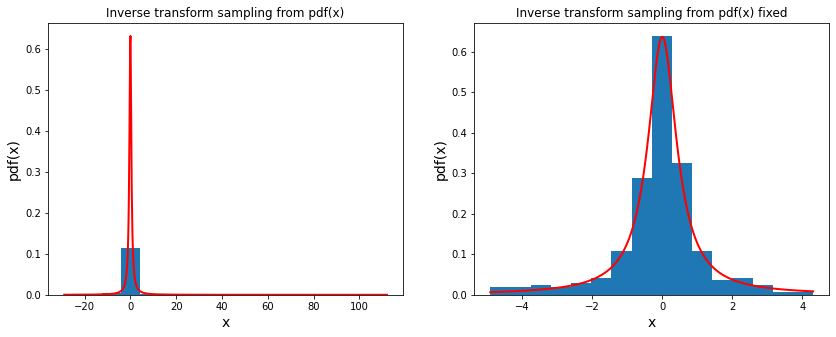

In [6]:
# Number of samples
n = 300

# Gamma parameter
gamma = 2.

# u ~ U[0, 1]
u = np.random.rand(n)

# Inverse transform sampling
X = kernel_exp_inverse_cdf(gamma, u)

# Plots
_, ax = plt.subplots(1, 2, figsize=(14, 5))

_ = stoch.plot_pdf(
    X, 
    lambda x: kernel_exp_pdf(gamma, x), 
    fontsize=14, 
    ax=ax[0],
)

# Try clipping axis
X_ = X[np.abs(X) < 5.]

_ = stoch.plot_pdf(
    X_, 
    lambda x: kernel_exp_pdf(gamma, x), 
    fontsize=14, 
    ax=ax[1],
)

# Set titles
ax[0].set_title('Inverse transform sampling from pdf(x)')
ax[1].set_title('Inverse transform sampling from pdf(x) fixed')

## Exponential kernel in $D$ dimensions.

Consider the exponential kernel in $D$ dimensions
$$ k(\mathbf{x}, \mathbf{x}') = k(\mathbf{x}- \mathbf{x}') = \exp\left\{- \frac{\lVert \mathbf{x}- \mathbf{x}' \rVert_1}{\gamma} \right\},$$
with the $L_1$ norm
$$ \lVert \mathbf{x}- \mathbf{x}' \rVert_1 = \sum_{d=1}^D \left|x_d \right|.$$

The Fourier transform of the exponential kernel in $D$ dimensions is proportional to a pdf:
$$
\text{pdf}(\mathbf{w}) \propto \int_{\mathbb{R}^D} e^{-i \mathbf{w}^T \mathbf{x}} \exp\left\{- \frac{\lVert \mathbf{x} \rVert_1}{\gamma} \right\} d \mathbf{x}.
$$

#### Q4. Compute the Fourier transform of the exponential kernel in $D$ dimensions.
The inverse Fourier transform of a translationally invariante kernel
$$
k(\mathbf{x}, \mathbf{x}') = k(\mathbf{x} - \mathbf{x}').
$$
is
$$
\text{pdf}(\mathbf{w}) = \frac{1}{\left(2 \pi\right)^D} \int_{\mathbb{R}^D} e^{- i \mathbf{w}^T \mathbf{x}} k(\mathbf{x}) d\mathbf{x}
$$

**Solution**.



$$
\begin{align*}
\hbox{pdf}(\mathbf{w}) 
    &= \frac{1}{\left(2 \pi\right)^D} \int_{\mathbb{R}^D} e^{- i \mathbf{w}^T \mathbf{x}} k(\mathbf{x}) d\mathbf{x} \\
    &= \frac{1}{\left(2 \pi\right)^D} \int_{\mathbb{R}^D} \exp \left\{ -i w^T x \right\} \exp \left\{ \frac{- |\mathbf{x}||_1}{\gamma} \right\} d\mathbf{x} \\
    &= 
\end{align*}
$$


#### Q5. Use the method of the inverse to generate random numbers sampled from $\text{pdf}(\mathbf{w})$.

*Hint:* If the 1D implementation is vectorized, the answer to this question is straightforward.


#### Q6. Write code to generate random Fourier Features corresponding to the exponential kernel in D dimensions.

Complete the code for the class 

```python
class RandomFeaturesSamplerExp(RandomFeaturesSampler):
```
in the file 
``` 
kernel_approximation.py
```



### Generation of Random Fourier Features: Alternative sampling scheme.

Consider the translationally invariant kernel $k\left(\mathbf{x}, \mathbf{x}'\right) = k\left(\mathbf{x} - \mathbf{x}'\right)$, with $\mathbf{x}, \mathbf{x}' \in \mathbb{R}^D$.

Acording to Bochner's theorem, this type of kernel can be expressed as the Fourier transform of a (possibly not normalized) density $p(\mathbf{w})$
$$
k\left(\mathbf{x} - \mathbf{x}'\right) = \int_{-\infty}^{\infty} d\mathbf{w} p\left(\mathbf{w}\right) e^{i \mathbf{w}^T \left(\mathbf{x} - \mathbf{x}'\right)}.
$$
Since the kernel funtion is real and symmetric, this expression can be written as 
$$
k\left(\mathbf{x} - \mathbf{x}'\right) = \int_{-\infty}^{\infty} d\mathbf{w} p\left(\mathbf{w}\right) \cos \left(\mathbf{w}^T \left(\mathbf{x} - \mathbf{x}'\right) \right).
$$

Show that the set of random features
$$
\left\{ \left( \cos \mathbf{w}^T \mathbf{x}, \sin \mathbf{w}^T \mathbf{x} \right); \mathbf{w} \sim p(\mathbf{w})\right\}.
$$
and the set 
$$
\left\{\sqrt{2} \cos \left(\mathbf{w}^T \mathbf{x} + b \right); \ \mathbf{w} \sim p(\mathbf{w}); \ b \sim U[0 , 2 \pi]; \ \mathbf{w} \perp b\right\}
$$
provide the same approximation of the kernel.

#### The kernel approximation using the first type of features is
$$
k\left(\mathbf{x}, \mathbf{x}'\right) = \int_{-\infty}^{\infty} d\mathbf{w} p(\mathbf{w}) \left( \cos \mathbf{w}^T \mathbf{x}, \, \sin \mathbf{w}^T \mathbf{x} \right) \left( \cos \mathbf{w}^T \mathbf{x}', \, \sin \mathbf{w}^T \mathbf{x}' \right)^T 
= \int_{-\infty}^{\infty} d\mathbf{w} p(\mathbf{w}) \left( \cos \mathbf{w}^T \mathbf{x}  \, \cos \mathbf{w}^T \mathbf{x}' + \sin \mathbf{w}^T \mathbf{x} \,  \sin \mathbf{w}^T \mathbf{x}' \right) = \int_{-\infty}^{\infty} d\mathbf{w} p(\mathbf{w}) \cos \left( \mathbf{w}^T \left( \mathbf{x} - \mathbf{x}' \right) \right).
$$

#### Q7. Derive the kernel approximation using the second type of features.

[YOUR ANSWER HERE]


#### Q8. Implement the sampling method based on the second type of random features.

Fill in the corresponding code in the file 
``` 
kernel_approximation.py
```

#### Q9. Illustrate that both types of feaures approximate the exponential kernel when $p(\mathbf{w})$ is the inverse Fourier transform of the exponential kernel in $D$ dimensions. 



In [7]:
## Generate data
# 3-D data
n_instances = 1000
X, t = datasets.make_s_curve(n_instances, noise=0.1)
X = X[np.argsort(t)]

In [5]:
# Approximate the exponential kernel using Random Fourier Features.

length_scale = 2.0
A = 1.0

def kernel(X, Y): 
    return kml.exponential_kernel( X, Y, A=1.0, l=length_scale)

## Create instances of the random features sampler

#  <YOUR ANSWER HERE>


### Q10. Train and evaluate different classifiers.

Solve the classification problem using different kernel methods using the same data in

https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py

**To get more stable results, the process should be repeated for $10$ different random train / test partitions of the data.**

Using 5-fold cross validation on the training data, determine the optimal values of the hyperparameter for the following cases: 
1. Non-linear SVM + RBF kernel [C, gamma]
2. Linear SVM + RBF random features [C, gamma, n_features]
3. Linear SVM + RBF Nyström features [C, gamma, n_features]
4. Non-linear SVM + exponential kernel [C, length_scale] 
5. Linear SVM + exponential random features [C, length_scale, n_features]
6. Linear SVM + exponential Nyström features [C, length_scale, n_features]

##### NOTES
* Determine the hyperparameter grid on which the search is made using references from the literature. Include those references in the Chicago citation format ( https://www.chicagomanualofstyle.org/tools_citationguide/citation-guide-2.html).

* It may be useful to vary one of the hyperparameters while keeping the other fixed (include those plots in your report). For instance, for $n_{features}$. 

##### REPORT:
* Plot the curve that traces the dependence of the CV, training and test error as a function of $n_{features}$ for a fixed value of the other parameters.
* Train final models with the values of the optimal hyperparameters.  
* Provide in a table the mean and the standard deviation of the training error, the cross-validation error and test error for each of the 6 methods considered.
* Provide in a table the mean and the standard deviation of the times for the cross-validation step, for the final training time, and for the prediction time in the test set. To this end, use the Python library $\texttt{timeit}$.

### Sklearn resources.

1. Non-linear SVM for classification: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

2. Linear SVM for classification: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

3. Cross-validation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

4. Timing and accuracy plots for random Fourier Features and Nyström features: https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html